In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from bfgs import bfgs
from gdstep import gd_steepest

In [159]:
def create_gaussian_sum_function(k=8, sigma=1.0, seed=42):
    """
    Crea una función de suma de gaussianas negativas CON RESTRICCIONES
    """
    np.random.seed(seed)
    centers = np.random.uniform(0, 8, size=(k, 2))
    
    def gaussian_sum(x):
        """Función con penalización fuera del dominio [0,8]x[0,8]"""
        x = np.array(x)
        
        # para evitar puntos fuera del dominio
        penalty = 0
        if np.any(x < 0) or np.any(x > 8):
            # Penalización cuadrática fuerte
            penalty = 1000 * (np.sum(np.maximum(0, -x)**2) + 
                             np.sum(np.maximum(0, x - 8)**2))
            return penalty
        
        x = x.reshape(1, -1)
        distances = cdist(x, centers, 'sqeuclidean')
        return -np.sum(np.exp(-distances / (2 * sigma)))
    
    def df_gaussian_sum(x):
        """Gradiente con protección de dominio"""
        x = np.array(x)
        
        # Si está fuera del dominio, gradiente apunta hacia adentro
        if np.any(x < 0) or np.any(x > 8):
            grad = np.zeros_like(x)
            for i in range(len(x)):
                if x[i] < 0:
                    grad[i] = 1000 * (-2 * x[i])  # Empuja hacia 0
                elif x[i] > 8:
                    grad[i] = 1000 * (-2 * (x[i] - 8))  # Empuja hacia 8
                else:
                    grad[i] = 0
            return grad
        
        # Gradiente normal dentro del dominio
        gradients = np.zeros_like(x)
        for center in centers:
            diff = x - center
            dist_sq = np.sum(diff**2)
            weight = np.exp(-dist_sq / (2 * sigma)) / sigma
            gradients += weight * diff
        return gradients
    
    return gaussian_sum, df_gaussian_sum, centers


In [160]:
# Crear la función de 8 gausianas (k=8, sigma =1.0)
f_gaussian, df_gaussian, centers = create_gaussian_sum_function(k=8, sigma=1.0, seed=42)

print("Centros de las gausianas:")
print(centers)

Centros de las gausianas:
[[2.99632095 7.60571445]
 [5.85595153 4.78926787]
 [1.24814912 1.24795616]
 [0.4646689  6.92940917]
 [4.80892009 5.66458062]
 [0.16467595 7.75927882]
 [6.65954113 1.69871289]
 [1.45459974 1.46723608]]


# Visualización de la función creada


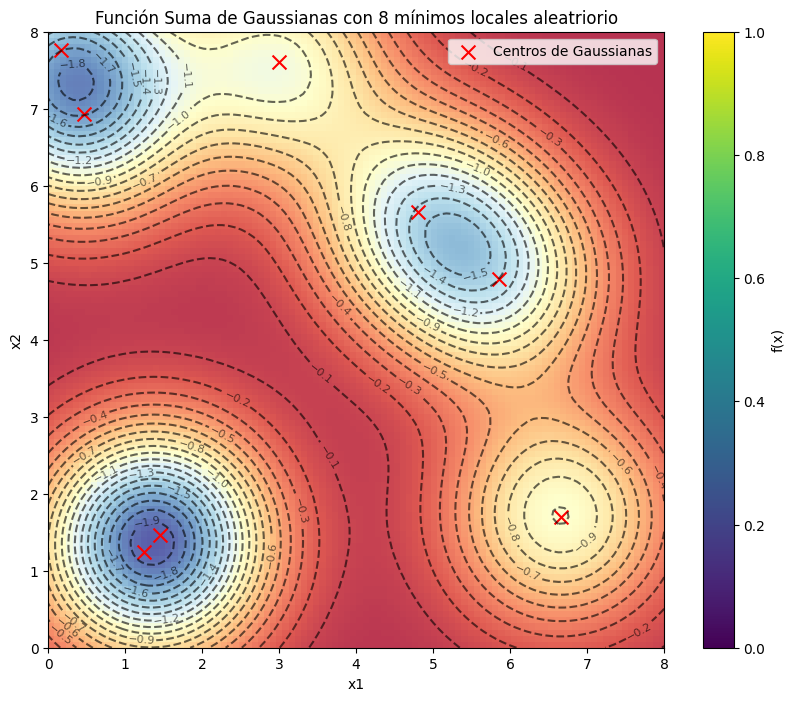

In [161]:
# Ver generado
xx, yy = np.meshgrid(np.linspace(0, 8, 100), np.linspace(0, 8, 100))
X_grid = np.vstack([xx.ravel(), yy.ravel()]).T
Z = np.array([f_gaussian(x) for x in X_grid]).reshape(xx.shape)

plt.figure(figsize=(10, 8))
contour = plt.contour(xx, yy, Z, levels=20, colors='black', alpha=0.6)
plt.clabel(contour, inline=True, fontsize=8)
plt.imshow(Z, extent=[0, 8, 0, 8], origin='lower', 
           cmap='RdYlBu_r', alpha=0.8)
plt.scatter(centers[:, 0], centers[:, 1], c='red', 
           s=100, marker='x', label='Centros de Gaussianas')
plt.colorbar(label='f(x)')
plt.title("Función Suma de Gaussianas con 8 mínimos locales aleatriorio")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.show()

In [162]:
np.random.seed(123)
initial_points = []

initial_points.extend(np.random.uniform(0, 8, size=(5, 2)))

# puntos cerca de los centros para que convergan
for center in centers:
    noise = np.random.normal(0, 0.5, size=(2,))  
    point = center + noise
    point = np.clip(point, 0, 8)  
    initial_points.append(point)

# 10 puntos
initial_points = np.array(initial_points)[:10]  

print("Puntos iniciales mejorados:")
for i, point in enumerate(initial_points):
    print(f"Punto {i+1}: {point}")


Puntos iniciales mejorados:
Punto 1: [5.57175348 2.28911468]
Punto 2: [1.81481163 4.41051815]
Punto 3: [5.75575176 3.38485168]
Punto 4: [7.84611359 5.47863791]
Punto 5: [3.84745521 3.13694015]
Punto 6: [3.62928908 7.17234425]
Punto 7: [5.51650846 4.74191339]
Punto 8: [1.99384394 0.92850516]
Punto 9: [0.24267792 6.71223353]
Punto 10: [5.91188514 6.75797367]


In [ ]:
results_minima = {}
all_trajectories = []

for i, x0 in enumerate(initial_points):
    print(f"Optimizando desde punto inicial {i+1}: {x0}")
    
    try:
        # STEEPEST DECENT
        xbest, xs, fxs, errs, it, cv = gd_steepest(
            f_gaussian, df_gaussian, x0, 
            alpha=1e-3,  
            tol=1e-4,    
            maxIter=15000, 
            stop="grad_norm"
        )
        
        # trayectoria completa
        trajectory = np.array(xs)
        all_trajectories.append(trajectory)
        
        # Redondear y almacenar
        #xbest_rounded = np.round(xbest, 2)
        f_val = f_gaussian(xbest)
        
        results_minima[f"Punto_{i+1}"] = {
            'x0': x0, 
            'x_best': xbest,
            'trajectory': trajectory,
            'f(x_best)': f_val,
            'minima_id': tuple(xbest),
            'converged': cv
        }
        
    except Exception as e:
        print(f"Error optimizando punto {i+1}: {e}")
        # Punto fallback si hay error
        results_minima[f"Punto_{i+1}"] = {
            'x0': x0, 
            'x_best': x0,  # Se queda en el inicial
            'trajectory': np.array([x0]),
            'f(x_best)': f_gaussian(x0),
            'minima_id': tuple(x0),
            'converged': False
        }

Optimizando desde punto inicial 1: [5.57175348 2.28911468]
Optimizando desde punto inicial 2: [1.81481163 4.41051815]
Optimizando desde punto inicial 3: [5.75575176 3.38485168]
Optimizando desde punto inicial 4: [7.84611359 5.47863791]
Optimizando desde punto inicial 5: [3.84745521 3.13694015]
Optimizando desde punto inicial 6: [3.62928908 7.17234425]
Optimizando desde punto inicial 7: [5.51650846 4.74191339]
Optimizando desde punto inicial 8: [1.99384394 0.92850516]
Optimizando desde punto inicial 9: [0.24267792 6.71223353]
Optimizando desde punto inicial 10: [5.91188514 6.75797367]


In [164]:
minima_found = []
for result in results_minima.values():
    xbest = result['x_best']
    # Solo considerar puntos dentro del dominio
    if np.all(xbest >= 0) and np.all(xbest <= 8):
        minima_found.append(xbest)

minima_array = np.array(minima_found)
unique_minima = np.unique(minima_array, axis=0)

print(f"\nMÍNIMOS LOCALES VÁLIDOS ENCONTRADOS dentro de [0,8]x[0,8] :")
for i, min_point in enumerate(unique_minima):
    f_val = f_gaussian(min_point)
    print(f"Mínimo {i+1}: {min_point}, f(x) = {f_val:.6f}")


MÍNIMOS LOCALES VÁLIDOS ENCONTRADOS dentro de [0,8]x[0,8] :
Mínimo 1: [0.35904525 7.34609562], f(x) = -1.842618
Mínimo 2: [0.44563067 7.21925782], f(x) = -1.825461
Mínimo 3: [1.35142011 1.35757097], f(x) = -1.977453
Mínimo 4: [2.86738351 7.53228741], f(x) = -1.087637
Mínimo 5: [5.32257885 5.23503964], f(x) = -1.589358
Mínimo 6: [5.32276864 5.2348765 ], f(x) = -1.589358
Mínimo 7: [5.32276887 5.23487686], f(x) = -1.589358
Mínimo 8: [5.32276891 5.23487688], f(x) = -1.589358
Mínimo 9: [5.32276893 5.23487683], f(x) = -1.589358
Mínimo 10: [6.654113 1.719139], f(x) = -1.006384


Estos son los minimos encontrados por todos los puntos, vemos que se repiten algunos porquee hay algunos puntos que convergieron en el mismo lugar.

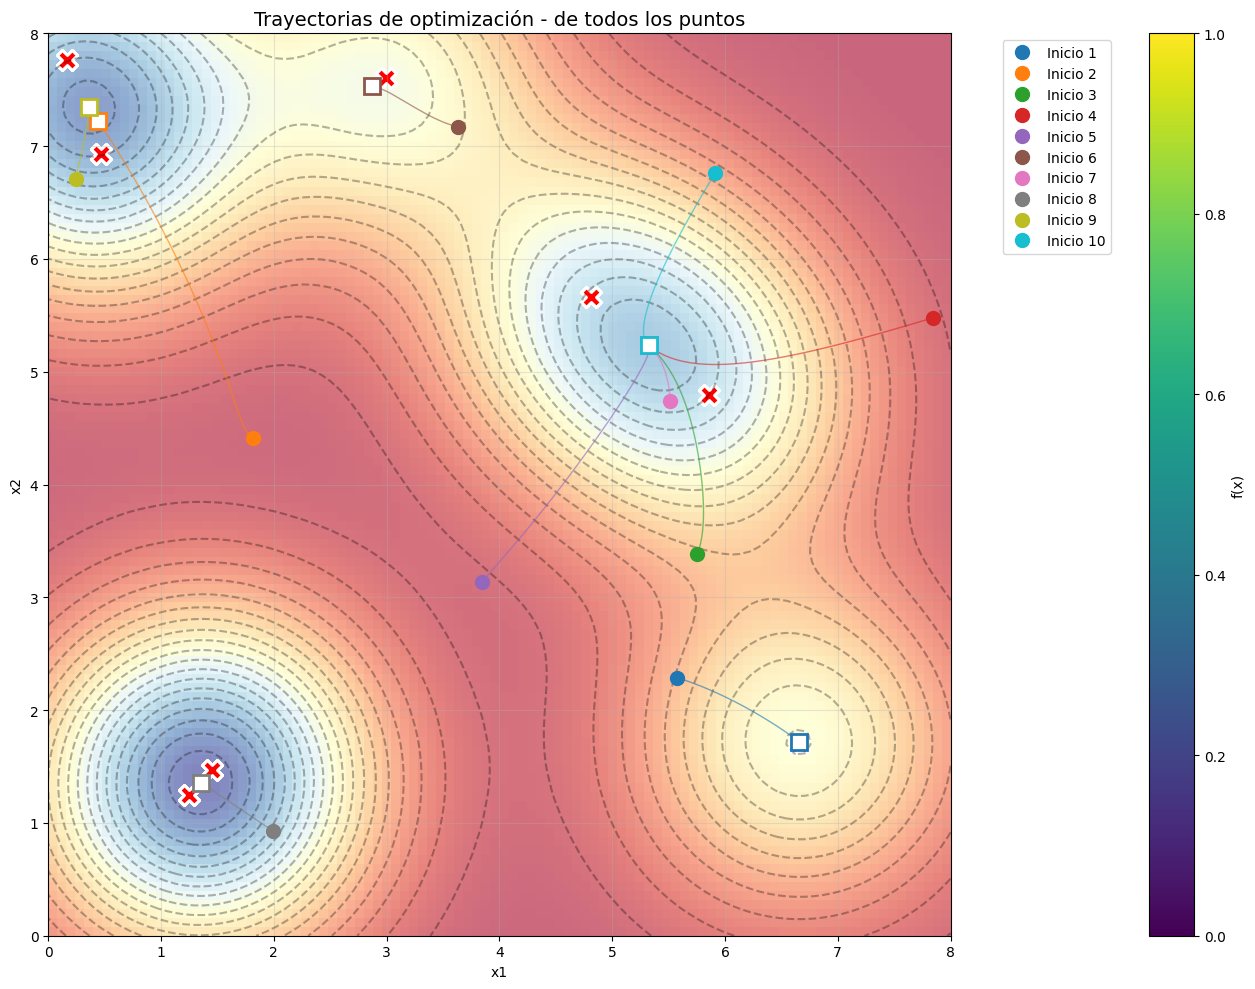

In [165]:
# resultado con trayectorias
plt.figure(figsize=(40, 10))

# Fondos de la función
plt.contour(xx, yy, Z, levels=20, colors='black', alpha=0.3)
plt.imshow(Z, extent=[0, 8, 0, 8], origin='lower', 
           cmap='RdYlBu_r', alpha=0.6)

# Plotear centros y trayectorias
colors = plt.cm.tab10(np.linspace(0, 1, len(initial_points)))

for i, (key, result) in enumerate(results_minima.items()):
    x0 = result['x0']
    xbest = result['x_best']
    trajectory = result['trajectory']
    
    # Trayectoria completa
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-', color=colors[i], 
             alpha=0.6, linewidth=1)
    plt.plot(trajectory[-10:, 0], trajectory[-10:, 1], 'o-', 
             color=colors[i], markersize=3, alpha=0.8)
    
    # Puntos inicial y final
    plt.plot(x0[0], x0[1], 'o', markersize=10, color=colors[i], 
             label=f'Inicio {i+1}')
    plt.plot(xbest[0], xbest[1], 's', markersize=12, color=colors[i],
             markerfacecolor='white', markeredgewidth=2)
    
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, 
           marker='X', edgecolors='white', linewidth=2)

plt.xlim(0, 8) 
plt.ylim(0, 8)
plt.title("Trayectorias de optimización - de todos los puntos", fontsize=14)
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.colorbar(label='f(x)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [171]:
# Tabla completa con punto inicial y mínimo
print("RESUMEN COMPLETO - PUNTOS INICIALES Y MÍNIMOS ENCONTRADOS")

print(f"{'#':<3} {'Punto Inicial':<20} {'→ Mínimo Encontrado':<20} {'f(x)':<12} {'¿Global?':<8} {'Centro más cercano':<20}")
print("-"*85)

global_min = np.inf
global_min_point = None

# Primero encontrar el global verdadero
for min_point in unique_minima:
    f_val = f_gaussian(min_point)
    if f_val < global_min:
        global_min = f_val
        global_min_point = min_point

# Ahora imprimir cada punto inicial con su mínimo
for i, (key, result) in enumerate(results_minima.items()):
    x0 = result['x0']
    xbest = result['x_best']
    f_val = result['f(x_best)']
    
    # redondeo de punto inical solo
    x0_str = str(np.round(x0, 2))
    # xbest_str = str(np.round(xbest, 2))
    
    is_global = "SÍ" if np.array_equal(xbest, global_min_point) else "No"
    
    closest_center = centers[np.argmin(np.linalg.norm(centers - xbest, axis=1))]
    closest_center_str = str(np.round(closest_center, 2))
    
    print(f"{i+1:<3} {str(x0_str):<20} {str(xbest):<20} {f_val:<12.6f} {is_global:<8} {closest_center_str:<20}")

RESUMEN COMPLETO - PUNTOS INICIALES Y MÍNIMOS ENCONTRADOS
#   Punto Inicial        → Mínimo Encontrado  f(x)         ¿Global? Centro más cercano  
-------------------------------------------------------------------------------------
1   [5.57 2.29]          [6.654113 1.719139]  -1.006384    No       [6.66 1.7 ]         
2   [1.81 4.41]          [0.44563067 7.21925782] -1.825461    No       [0.46 6.93]         
3   [5.76 3.38]          [5.32276893 5.23487683] -1.589358    No       [4.81 5.66]         
4   [7.85 5.48]          [5.32276891 5.23487688] -1.589358    No       [4.81 5.66]         
5   [3.85 3.14]          [5.32276864 5.2348765 ] -1.589358    No       [4.81 5.66]         
6   [3.63 7.17]          [2.86738351 7.53228741] -1.087637    No       [3.   7.61]         
7   [5.52 4.74]          [5.32276887 5.23487686] -1.589358    No       [4.81 5.66]         
8   [1.99 0.93]          [1.35142011 1.35757097] -1.977453    SÍ       [1.45 1.47]         
9   [0.24 6.71]          [0.359045

# Tabla final


| #  | Punto Inicial        | Mínimo Encontrado           | f(x)       | ¿Global? | Centro más cercano |
|:--:|:------------------- |:--------------------------- |:---------- |:---------|:----------------- |
| 1  | [5.57, 2.29]        | [6.654113, 1.719139]       | -1.006384  | No       | [6.66, 1.7]       |
| 2  | [1.81, 4.41]        | [0.44563067, 7.21925782]  | -1.825461  | No       | [0.46, 6.93]      |
| 3  | [5.76, 3.38]        | [5.32276893, 5.23487683]  | -1.589358  | No       | [4.81, 5.66]      |
| 4  | [7.85, 5.48]        | [5.32276891, 5.23487688]  | -1.589358  | No       | [4.81, 5.66]      |
| 5  | [3.85, 3.14]        | [5.32276864, 5.2348765]   | -1.589358  | No       | [4.81, 5.66]      |
| 6  | [3.63, 7.17]        | [2.86738351, 7.53228741]  | -1.087637  | No       | [3.0, 7.61]       |
| 7  | [5.52, 4.74]        | [5.32276887, 5.23487686]  | -1.589358  | No       | [4.81, 5.66]      |
| 8  | [1.99, 0.93]        | [1.35142011, 1.35757097]  | -1.977453  | Sí       | [1.45, 1.47]      |
| 9  | [0.24, 6.71]        | [0.35904525, 7.34609562]  | -1.842618  | No       | [0.46, 6.93]      |
| 10 | [5.91, 6.76]        | [5.32257885, 5.23503964]  | -1.589358  | No       | [4.81, 5.66]      |

